# Sentiment Analysis

#### First, let's import all the python libraries that we will use throughout the program. 

#### Basic Python Libraries
1. Pandas - library for data analysis and data manipulation
2. Matplotlib - library used for data visualization
3. Seaborn - library based on matplotlib and it provides a high level interface for data visualization
4. WordCloud - library to visualize text data
3. re - provides functions to pre process the strings as per the given regular expression

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import re
import pickle
from sklearn.pipeline import Pipeline

#### Now we will import style and rcParams from matplotlib to modify the style of graphs. And, we will import warnings library, to ignore the unnecessary warnings which are displayed.

In [2]:
from matplotlib import style,rcParams
style.use('seaborn-white')
rcParams['figure.figsize'] = 10,5
import warnings
warnings.filterwarnings('ignore')

#### Natural Language Processing
1. nltk - Natural Language Toolkit is a collection of libraries for natural language processing
2. stopwords - collection of words that don't provide any meaning to a sentence
3. WordNetLemmatizer - used to convert different forms of words into a single item but still keeping the context intact

In [3]:
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

#### Scikit-Learn (Machine Learning Library for Python)
1. CountVectorizer - transform text to vectors
2. train_test_split - splits data into train and test data
3. GridSearchCV - for hyperparameter tuning
4. RandomForestClassifier - machine learning algorithm for classification

In [4]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

#### Evaluation Metrics
1. Accuracy Score - no. of correctly classified instances/total no. of istances
2. Precision Score
3. Recall Score
4. Roc Curve
5. Classification Report
6. Confusion Matrix

In [5]:
from sklearn.metrics import accuracy_score,precision_score,recall_score,confusion_matrix,roc_curve,classification_report
from scikitplot.metrics import plot_confusion_matrix

#### Now, we will read the training data and validation data. As the data is in text format, seperated by semi colons and without column names, we will create the data frame with read_csv() and parameters as "delimeter" and "names".

In [6]:
df_train = pd.read_csv("train.txt",delimiter=';',names=['text','label'])
df_val = pd.read_csv("val.txt",delimiter=';',names=['text','label'])

#### Now, we will concatenate these two data frames as we will be using cross validation and we have a seperate test dataset.

In [7]:
df = pd.concat([df_train,df_val])

In [8]:
print("Shape of the DataFrame:",df.shape)

Shape of the DataFrame: (18000, 2)


In [9]:
df.reset_index(inplace=True,drop=True)

In [10]:
print("Shape of the DataFrame:",df.shape)
df.sample(5)

Shape of the DataFrame: (18000, 2)


,text,label
2960,i felt rich being able to insist on paying mor...,joy
12469,i feel somewhat hopeless and pitiful,sadness
14769,i was feeling rather smug about being a black ...,joy
16293,i am sure she makes all waiting couples feel t...,joy
17961,i feel more well rested though my sinuses stil...,joy


<AxesSubplot:xlabel='label', ylabel='count'>

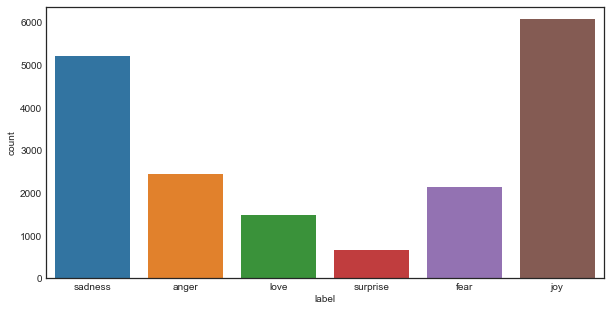

In [11]:
sns.countplot(df.label)

#### As we can see that, we have 6 labels or targets in the dataset. We can make a multi-class classifier for Sentiment Analysis. But, for the sake of the simplicity, we will merge these labels into two classes, i.e. Positive or Negative sentiment.

1. Positive Sentiment - "joy","love","surprise"
2. Negative Sentiment - "anger","sadness","fear"

#### Now, we will create a custom encoder to convert categorical target labels to numerical form, i.e. (0 and 1)

In [12]:
def custom_encoder(df):
    df.replace(to_replace ="surprise", value =1, inplace=True)
    df.replace(to_replace ="love", value =1, inplace=True)
    df.replace(to_replace ="joy", value =1, inplace=True)
    df.replace(to_replace ="fear", value =0, inplace=True)
    df.replace(to_replace ="anger", value =0, inplace=True)
    df.replace(to_replace ="sadness", value =0, inplace=True)

In [13]:
custom_encoder(df['label'])

<AxesSubplot:xlabel='label', ylabel='count'>

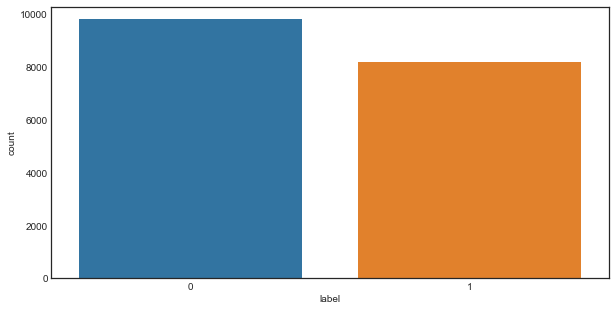

In [14]:
sns.countplot(df.label)

#### Now, we can see that our target have changed to 0 and 1, and the data is more or less in a balanced state.

In [15]:
df.head()

,text,label
0,i didnt feel humiliated,0
1,i can go from feeling so hopeless to so damned...,0
2,im grabbing a minute to post i feel greedy wrong,0
3,i am ever feeling nostalgic about the fireplac...,1
4,i am feeling grouchy,0


#### Now, we will perform some pre-processing on the data before converting it into vectors and passing it to the machine learning model.

In [16]:
#object of WordNetLemmatizer
lm = WordNetLemmatizer()

#### We will create a function for pre-processing of data
1. First, we will iterate through each record and using regualr expression, we will get rid of any characters apart from alphabets.
2. Then, we will convert the string to lowercase as, the word "Good" is different from the word "good". This will cause an issue, when we will create vectors of these words, as two different vectors will be created for the same word which we don't want to.
3. Then we will check for stopwords in the data and get rid of them. Stopwords are commonly used words in a sentence such as "the","an","to" etc. which do not add much value.
4. Then, we will perform lemmatization on each word,i.e. change the different forms of word into a single item called as lemma. A lemma is a base form of a word. For example, run, running and runs are all forms of same lexeme where run is the lemma. Hence, we are converting all occurrences of same lexeme to it's respective lemma.
5. And, then return a corpus of processed data

In [17]:
def text_transformation(df_col):
    corpus = []
    for item in df_col:
        new_item = re.sub('[^a-zA-Z]',' ',str(item))
        new_item = new_item.lower()
        new_item = new_item.split()
        new_item = [lm.lemmatize(word) for word in new_item if word not in set(stopwords.words('english'))]
        corpus.append(' '.join(str(x) for x in new_item))
    return corpus

In [18]:
corpus = text_transformation(df['text'])

In [19]:
type(corpus)

list

#### Now, we will create a Word Cloud. It is a data visualization technique used to depict text in such a way that, the more frequent words appear enlarged as compared to less frequent words.

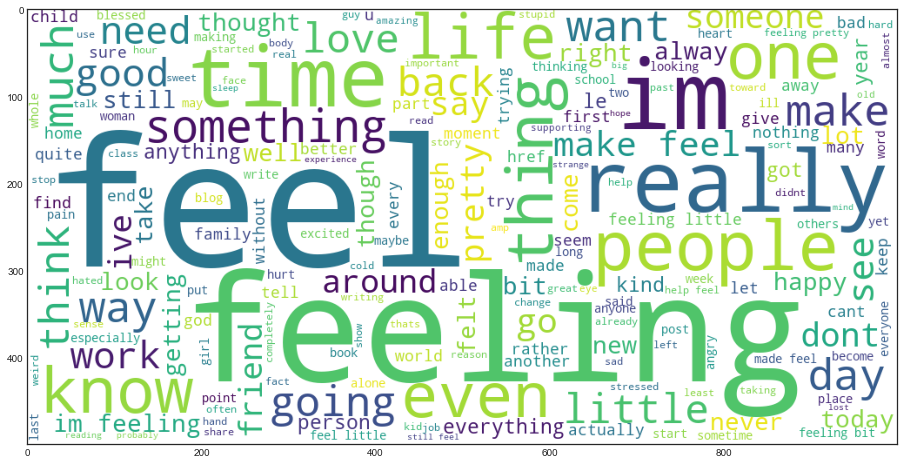

In [20]:
rcParams['figure.figsize'] = 20,8
word_cloud = ""
for row in corpus:
    for word in row:
        word_cloud+=" ".join(word)

wordcloud = WordCloud(width = 1000, height = 500,background_color ='white',min_font_size = 10).generate(word_cloud)
plt.imshow(wordcloud)

#### Now, we will use Bag of Words Model(BOW), which is used to represent the text in the form of bag of words,i.e. the grammar and the order of words in a sentence is not given any importance, instead multiplicity,i.e. (the number of times a word occurs in a document) is the main point of concern.
#### Basically, it describes the total occurrence of words within a document.

#### sklearn provides a neat way of performing bag of words technique using CountVectorizer

In [21]:
from sklearn.feature_extraction.text import CountVectorizer

#### Now, we will convert the text data into vectors, by fitting and transforming the corpus.
#### We will take ngram_range as (1,2) which signifies a bigram. 
#### Ngram is a sequence of 'n' of words in a row or sentence. 'ngram_range' is parameter which we use to give importance to combination of words as well, such as, "social media" has different meaning then separate words such as "social" and "media".
#### We can use experiment with the value of this parameter and select the option which gives better results.


In [22]:
cv = CountVectorizer(ngram_range=(1,2))
traindata = cv.fit_transform(corpus)

In [23]:
X = traindata
y = df.label

In [24]:
rfc = RandomForestClassifier(max_features='sqrt',
                                      max_depth=None,
                                      n_estimators=1000,
                                      min_samples_split=5,
                                      min_samples_leaf=1,
                                      bootstrap='True')

In [25]:
pipeline = Pipeline(steps= [('cvector', CountVectorizer(ngram_range=(1,2))),
('model', RandomForestClassifier(max_features='sqrt',
                                      max_depth=None,
                                      n_estimators=1000,
                                      min_samples_split=5,
                                      min_samples_leaf=1,
                                      bootstrap='True'))])
#fit the pipeline model with the training data
pipeline.fit(corpus,y)

Pipeline(steps=[('cvector', CountVectorizer(ngram_range=(1, 2))),
                ('model',
                 RandomForestClassifier(bootstrap='True', max_features='sqrt',
                                        min_samples_split=5,
                                        n_estimators=1000))])

In [26]:
file = open('sentiment_analysis_model.pkl', 'wb')

pickle.dump(pipeline, file)

#### Now, we will train our new model.

## Test Data Transformation
#### Now, we will read the test data and perform the same transformations we did on training data and finally evaluate the model on it's predictions.

In [27]:
test_df = pd.read_csv('test.txt',delimiter=';',names=['text','label'])

In [28]:
X_test,y_test = test_df.text,test_df.label
#encode the labels into two classes , 0 and 1
test_df = custom_encoder(y_test)
#pre-processing of text
test_corpus = text_transformation(X_test)
#convert text data into vectors
#testdata = cv.transform(test_corpus)
#predict the target
#predictions = rfc.predict(testdata)

predictions = pipeline.predict(test_corpus)

### Model Evaluation Metrics

Accuracy_score:  0.9615
Precision_score:  0.9616648411829135
Recall_score:  0.9543478260869566
-------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.96      0.97      0.96      1080
           1       0.96      0.95      0.96       920

    accuracy                           0.96      2000
   macro avg       0.96      0.96      0.96      2000
weighted avg       0.96      0.96      0.96      2000



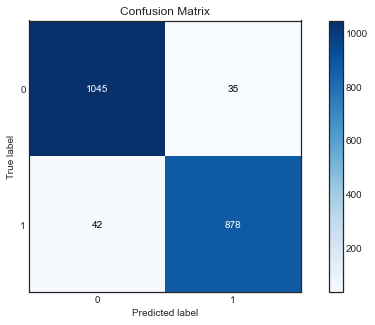

In [29]:
rcParams['figure.figsize'] = 10,5
plot_confusion_matrix(y_test,predictions)
acc_score = accuracy_score(y_test,predictions)
pre_score = precision_score(y_test,predictions)
rec_score = recall_score(y_test,predictions)
print('Accuracy_score: ',acc_score)
print('Precision_score: ',pre_score)
print('Recall_score: ',rec_score)
print('-------------------------------------------------------------------')
cr = classification_report(y_test,predictions)
print(cr)

In [30]:
#predictions_probability = rfc.predict_proba(testdata)
predictions_probability = pipeline.predict_proba(test_corpus)

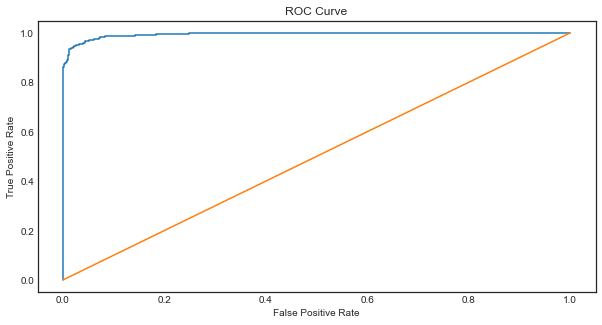

In [31]:
fpr,tpr,thresholds = roc_curve(y_test,predictions_probability[:,1])
plt.plot(fpr,tpr)
plt.plot([0,1])
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

## Predict for Custom Input

In [26]:
def expression_check(prediction_input):
    if prediction_input == 0:
        print("Input statement has Negative Sentiment.")
    elif prediction_input == 1:
        print("Input statement has Positive Sentiment.")
    else:
        print("Invalid Statement.")

In [27]:
def sentiment_predictor(input):
    input = text_transformation(input)
    #transformed_input = cv.transform(input)
    #prediction = rfc.predict(transformed_input)
    prediction = pipeline.predict(input)
    expression_check(prediction)

In [28]:
input1 = ["Sometimes I just want to punch someone in the face."]
input2 = ["I bought a new phone and it's so good."]
sentiment_predictor(input1)
sentiment_predictor(input2)

Input statement has Negative Sentiment.
Input statement has Positive Sentiment.


In [29]:
input = text_transformation(input2)

In [30]:
prediction = pipeline.predict(input)

In [31]:
xyz = int(prediction[0])

In [32]:
type(xyz)

int

# The END